In [92]:
# write the redundent code into functions

# Import Statements

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

# Opening the File to see the list of parameters

### Pass 5.1

In [2]:
pass5file = '/home/rykore/pass5.1/2.63_3.45e-11_1000000_35_1.0_combined_rec.root'

with uproot.open(pass5file) as file:
    t = file['XCDF']
    t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec.status           | uint64_t                 | AsDtype('>u8')
rec.version          | uint64_t                 | AsDtype('>u8')
rec.eventID          | uint64_t                 | AsDtype('>u8')
rec.runID            | uint64_t                 | AsDtype('>u8')
rec.timeSliceID      | uint64_t                 | AsDtype('>u8')
rec.trigger_flags    | uint64_t                 | AsDtype('>u8')
rec.event_flags      | uint64_t                 | AsDtype('>u8')
rec.gtc_flags        | uint64_t                 | AsDtype('>u8')
rec.gpsSec           | uint64_t                 | AsDtype('>u8')
rec.gpsNanosec       | uint64_t                 | AsDtype('>u8')
rec.nChTot           | uint64_t                 | AsDtype('>u8')
rec.nChAvail         | uint64_t                 | AsDtype('>u8')
rec.nHitTot          | uint64_t                 | AsDtype(

### Pass 4

In [3]:
pass4file = '/home/rykore/pass4/2.63_3.45e-11_1000000_0_1.0_combined_rec.root'

with uproot.open(pass4file) as file:
    t = file['XCDF']
    t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec.nFit             | uint64_t                 | AsDtype('>u8')
rec.status           | uint64_t                 | AsDtype('>u8')
rec.version          | uint64_t                 | AsDtype('>u8')
rec.eventID          | uint64_t                 | AsDtype('>u8')
rec.runID            | uint64_t                 | AsDtype('>u8')
rec.timeSliceID      | uint64_t                 | AsDtype('>u8')
rec.trigger_flags    | uint64_t                 | AsDtype('>u8')
rec.event_flags      | uint64_t                 | AsDtype('>u8')
rec.gtc_flags        | uint64_t                 | AsDtype('>u8')
rec.gpsSec           | uint64_t                 | AsDtype('>u8')
rec.gpsNanosec       | uint64_t                 | AsDtype('>u8')
rec.nChTot           | uint64_t                 | AsDtype('>u8')
rec.nChAvail         | uint64_t                 | AsDtype(

# Redefining variables based on what is needed

### Pass 5.1

In [56]:
dset = dict()

with uproot.open(pass5file) as file:
    t = file['XCDF']
    dset["zenithAngle"] = t["rec.zenithAngle"].array(library="np")
    dset["azimuthAngle"] = t["rec.azimuthAngle"].array(library="np")
    dset["nHit"] = t["rec.nHit"].array(library="np")  # nHit > 75 - new cut
    dset["protonlheEnergy"] = t["rec.protonlheEnergy"].array(library="np")  # reconstructed proton energy
    dset["PINC"] = t["rec.PINC"].array(library="np")
    dset["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np") 
    dset["angleFitStatus"] = t["rec.angleFitStatus"].array(library="np")
    dset["coreFitStatus"] = t["rec.coreFitStatus"].array(library="np")
    # fit status of the reconstruction, 0 meaning successfull and != 0 means unsuccessful
    dset["cuts"] = np.logical_and(dset["angleFitStatus"] == 0, dset["coreFitStatus"] == 0)
    dset["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
    dset["weights"] = t["sweets.IWgt"].array(library="np")
    # corsikaParticleId != 1 - Excludes gamma rays
    dset["cuts"] = np.logical_and(dset["cuts"] , dset["corsikaParticleId"]!=1 , dset["nHit"] > 75)
    # dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2, dset["CxPE40XnCh"] > 40)
    dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2)
    dset["logEnergy"] = t["mc.logEnergy"].array(library="np")  # true energy
    dset["logNNEnergy"] = t["rec.logNNEnergy"].array(library="np")  # reconstructed energy

In [57]:
initial_cuts_5 = dset["cuts"]
zenith_angle_5 = dset["zenithAngle"][initial_cuts_5]
nHit_5 = dset["nHit"][initial_cuts_5]
pinc_5 = dset["PINC"][initial_cuts_5]
true_log_E_5 = dset["logEnergy"][initial_cuts_5]
rec_log_nnE_5 = dset["logNNEnergy"][initial_cuts_5]
rec_prot_E_5 = ((dset["protonlheEnergy"][initial_cuts_5]) - 9)
weights_5 = dset["weights"][initial_cuts_5]

In [51]:
len(dset["logNNEnergy"])
len(dset["protonlheEnergy"])
len(initial_cuts_5)

29035661

In [52]:
len(rec_log_nnE_5)
len(rec_prot_E_5)

5185506

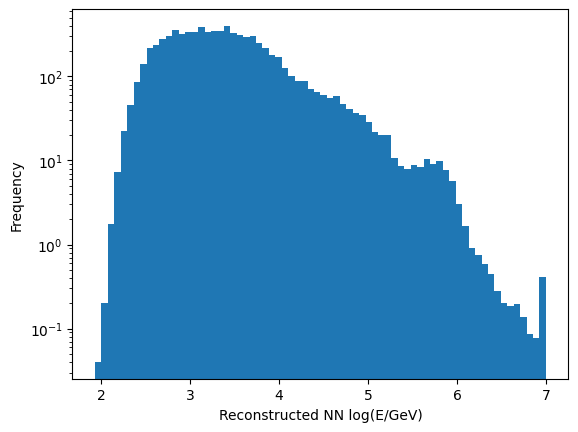

In [8]:
# adding weights - gives the simulated data a weight to make it closer to the actual data
plt.hist(rec_log_nnE_5, bins = 70, log=True, weights = weights_5)
plt.xlabel("Reconstructed NN log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

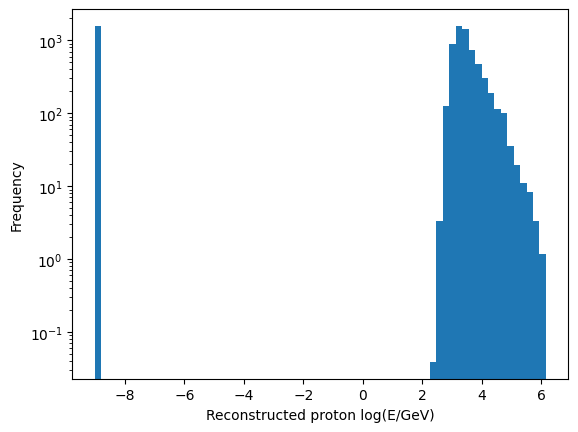

In [9]:
# when the cuts are applied, that -ve log value automatically gets excluded
plt.hist(rec_prot_E_5, bins = 70, log=True, weights = weights_5)
plt.xlabel("Reconstructed proton log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

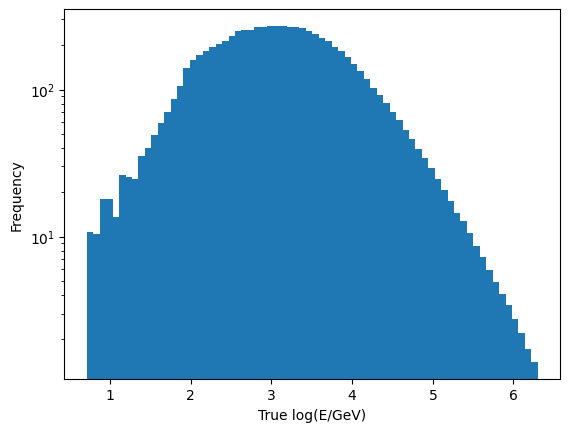

In [10]:
plt.hist(true_log_E_5, bins = 70, log=True, weights = weights_5)
plt.xlabel("True log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

### Pass 4

In [64]:
dset = dict()

with uproot.open(pass4file) as file:
    t = file['XCDF']
    dset["zenithAngle"] = t["rec.zenithAngle"].array(library="np")
    dset["azimuthAngle"] = t["rec.azimuthAngle"].array(library="np")
    dset["nHit"] = t["rec.nHit"].array(library="np")  # nHit > 75 - new cut
    dset["protonlheEnergy"] = t["rec.protonlheEnergy"].array(library="np")  # reconstructed proton energy
    dset["PINC"] = t["rec.PINC"].array(library="np")
    dset["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np") 
    dset["angleFitStatus"] = t["rec.angleFitStatus"].array(library="np")
    dset["coreFitStatus"] = t["rec.coreFitStatus"].array(library="np")
    # fit status of the reconstruction, 0 meaning successfull and != 0 means unsuccessful
    dset["cuts"] = np.logical_and(dset["angleFitStatus"] == 0, dset["coreFitStatus"] == 0)
    dset["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
    dset["weights"] = t["sweets.IWgt"].array(library="np")
    # corsikaParticleId != 1 - Excludes gamma rays
    dset["cuts"] = np.logical_and(dset["cuts"] , dset["corsikaParticleId"]!=1 , dset["nHit"] > 75)
    # dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2, dset["CxPE40XnCh"] > 40)  # as per the paper
    dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2)
    dset["logEnergy"] = t["mc.logEnergy"].array(library="np")  # true energy
    dset["logNnEnergy"] = t["rec.logNnEnergy"].array(library="np")  # reconstructed energy

In [65]:
initial_cuts_4 = dset["cuts"]
zenith_angle_4 = dset["zenithAngle"][initial_cuts_4]
nHit_4 = dset["nHit"][initial_cuts_4]
pinc_4 = dset["PINC"][initial_cuts_4]
true_log_E_4 = dset["logEnergy"][initial_cuts_4]
rec_log_nnE_4 = dset["logNnEnergy"][initial_cuts_4]
rec_prot_E_4 = ((dset["protonlheEnergy"][initial_cuts_4]) - 9)
weights_4 = dset["weights"][initial_cuts_4]

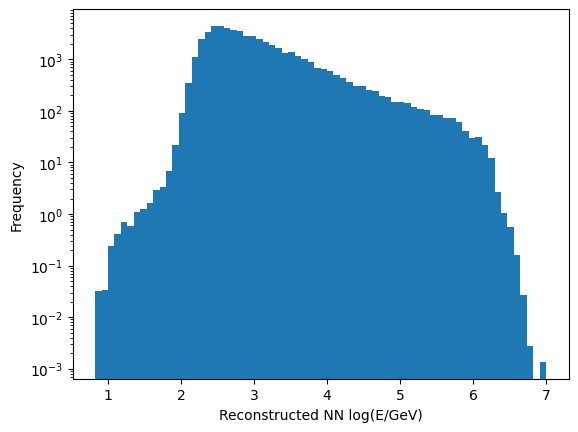

In [13]:
# adding weights - gives the simulated data a weight to make it closer to the actual data
plt.hist(rec_log_nnE_4, bins = 70, log=True, weights = weights_4)
plt.xlabel("Reconstructed NN log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

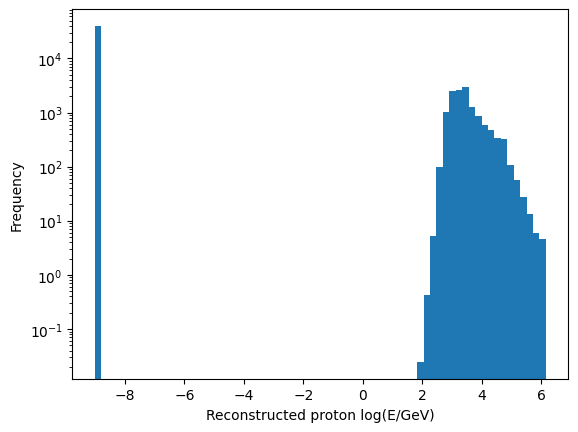

In [14]:
plt.hist(rec_prot_E_4, bins = 70, log=True, weights = weights_4)
plt.xlabel("Reconstructed proton log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

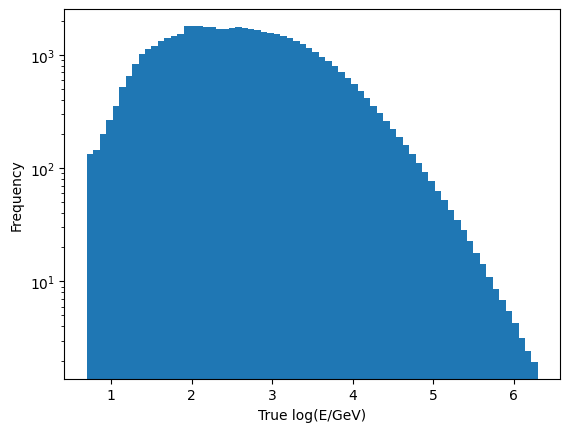

In [15]:
plt.hist(true_log_E_4, bins = 70, log=True, weights = weights_4)
plt.xlabel("True log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

# Cutting and binning the Energy

cut 1 = 1 Tev - 10 TeV  \
cut 2 = 10 TeV - 30 TeV\
cut 3 = 30 TeV - 50 TeV\
cut 4 = 50 TeV - 70 TeV\
cut 5 = 70 TeV - 100 TeV\
cut 6 = 100 TeV - 200 TeV\
cut 7 = 200 TeV - 300 TeV

In [16]:
# reconstructed nn energy cuts for pass 5.1
rec_nn_cut1_5 = np.logical_and(rec_log_nnE_5 >= np.log10(1e3),rec_log_nnE_5 < np.log10(1e4))
rec_nn_cut2_5 = np.logical_and(rec_log_nnE_5 >= np.log10(1e4),rec_log_nnE_5 < np.log10(3e4))
rec_nn_cut3_5 = np.logical_and(rec_log_nnE_5 >= np.log10(3e4),rec_log_nnE_5 < np.log10(5e4))
rec_nn_cut4_5 = np.logical_and(rec_log_nnE_5 >= np.log10(5e4),rec_log_nnE_5 < np.log10(7e4))
rec_nn_cut5_5 = np.logical_and(rec_log_nnE_5 >= np.log10(7e4),rec_log_nnE_5 < np.log10(1e5))
rec_nn_cut6_5 = np.logical_and(rec_log_nnE_5 >= np.log10(1e5),rec_log_nnE_5 < np.log10(2e5))
rec_nn_cut7_5 = np.logical_and(rec_log_nnE_5 >= np.log10(2e5),rec_log_nnE_5 <= np.log10(3e5))

In [17]:
# reconstructed proton energy cuts for pass 5.1
rec_prot_cut1_5 = np.logical_and(rec_prot_E_5 >= np.log10(1e3),rec_prot_E_5 < np.log10(1e4))
rec_prot_cut2_5 = np.logical_and(rec_prot_E_5 >= np.log10(1e4),rec_prot_E_5 < np.log10(3e4))
rec_prot_cut3_5 = np.logical_and(rec_prot_E_5 >= np.log10(3e4),rec_prot_E_5 < np.log10(5e4))
rec_prot_cut4_5 = np.logical_and(rec_prot_E_5 >= np.log10(5e4),rec_prot_E_5 < np.log10(7e4))
rec_prot_cut5_5 = np.logical_and(rec_prot_E_5 >= np.log10(7e4),rec_prot_E_5 < np.log10(1e5))
rec_prot_cut6_5 = np.logical_and(rec_prot_E_5 >= np.log10(1e5),rec_prot_E_5 < np.log10(2e5))
rec_prot_cut7_5 = np.logical_and(rec_prot_E_5 >= np.log10(2e5),rec_prot_E_5 <= np.log10(3e5))

In [18]:
# reconstructed nn energy cuts for pass 4
rec_nn_cut1_4 = np.logical_and(rec_log_nnE_4 >= np.log10(1e3),rec_log_nnE_4 < np.log10(1e4))
rec_nn_cut2_4 = np.logical_and(rec_log_nnE_4 >= np.log10(1e4),rec_log_nnE_4 < np.log10(3e4))
rec_nn_cut3_4 = np.logical_and(rec_log_nnE_4 >= np.log10(3e4),rec_log_nnE_4 < np.log10(5e4))
rec_nn_cut4_4 = np.logical_and(rec_log_nnE_4 >= np.log10(5e4),rec_log_nnE_4 < np.log10(7e4))
rec_nn_cut5_4 = np.logical_and(rec_log_nnE_4 >= np.log10(7e4),rec_log_nnE_4 < np.log10(1e5))
rec_nn_cut6_4 = np.logical_and(rec_log_nnE_4 >= np.log10(1e5),rec_log_nnE_4 < np.log10(2e5))
rec_nn_cut7_4 = np.logical_and(rec_log_nnE_4 >= np.log10(2e5),rec_log_nnE_4 <= np.log10(3e5))
# rec_cut5_4 = rec_log_nnE_4 > np.log10(7e4)

In [19]:
# true cuts for pass 4
rec_prot_cut1_4 = np.logical_and(rec_prot_E_4 >= np.log10(1e3),rec_prot_E_4 < np.log10(1e4))
rec_prot_cut2_4 = np.logical_and(rec_prot_E_4 >= np.log10(1e4),rec_prot_E_4 < np.log10(3e4))
rec_prot_cut3_4 = np.logical_and(rec_prot_E_4 >= np.log10(3e4),rec_prot_E_4 < np.log10(5e4))
rec_prot_cut4_4 = np.logical_and(rec_prot_E_4 >= np.log10(5e4),rec_prot_E_4 < np.log10(7e4))
rec_prot_cut5_4 = np.logical_and(rec_prot_E_4 >= np.log10(7e4),rec_prot_E_4 < np.log10(1e5))
rec_prot_cut6_4 = np.logical_and(rec_prot_E_4 >= np.log10(1e5),rec_prot_E_4 < np.log10(2e5))
rec_prot_cut7_4 = np.logical_and(rec_prot_E_4 >= np.log10(2e5),rec_prot_E_4 <= np.log10(3e5))
# true_cut5_4 = true_log_E_4 > np.log10(7e4)

## Pass 5.1

### Rec NN Energy

In [20]:
# applying the reconstructed nn energy cuts on the true energy

nn_energy_cut1_5 = true_log_E_5[rec_nn_cut1_5]
nn_energy_cut2_5 = true_log_E_5[rec_nn_cut2_5]
nn_energy_cut3_5 = true_log_E_5[rec_nn_cut3_5]
nn_energy_cut4_5 = true_log_E_5[rec_nn_cut4_5]
nn_energy_cut5_5 = true_log_E_5[rec_nn_cut5_5]
nn_energy_cut6_5 = true_log_E_5[rec_nn_cut6_5]
nn_energy_cut7_5 = true_log_E_5[rec_nn_cut7_5]

nn_energies_5 = [nn_energy_cut1_5, nn_energy_cut2_5, nn_energy_cut3_5, nn_energy_cut4_5, nn_energy_cut5_5, nn_energy_cut6_5, nn_energy_cut7_5]

In [21]:
# weight cuts with reconstructed nn energy for pass 5.1

nn_weights_cut1_5 = weights_5[rec_nn_cut1_5]
nn_weights_cut2_5 = weights_5[rec_nn_cut2_5]
nn_weights_cut3_5 = weights_5[rec_nn_cut3_5]
nn_weights_cut4_5 = weights_5[rec_nn_cut4_5]
nn_weights_cut5_5 = weights_5[rec_nn_cut5_5]
nn_weights_cut6_5 = weights_5[rec_nn_cut6_5]
nn_weights_cut7_5 = weights_5[rec_nn_cut7_5]

nn_weights_array_5 = [nn_weights_cut1_5, nn_weights_cut2_5, nn_weights_cut3_5, nn_weights_cut4_5, nn_weights_cut5_5, nn_weights_cut6_5, nn_weights_cut7_5]

In [22]:
# zenith angle cuts with reconstructed nn energy for pass 5.1

nn_zenith_cut1_5 = zenith_angle_5[rec_nn_cut1_5]
nn_zenith_cut2_5 = zenith_angle_5[rec_nn_cut2_5]
nn_zenith_cut3_5 = zenith_angle_5[rec_nn_cut3_5]
nn_zenith_cut4_5 = zenith_angle_5[rec_nn_cut4_5]
nn_zenith_cut5_5 = zenith_angle_5[rec_nn_cut5_5]
nn_zenith_cut6_5 = zenith_angle_5[rec_nn_cut6_5]
nn_zenith_cut7_5 = zenith_angle_5[rec_nn_cut7_5]

nn_zenith_array_5 = [nn_zenith_cut1_5, nn_zenith_cut2_5, nn_zenith_cut3_5, nn_zenith_cut4_5, nn_zenith_cut5_5, nn_zenith_cut6_5, nn_zenith_cut7_5]

### Rec Proton Energy

In [23]:
# applying the reconstructed proton energy cuts on the true energy

prot_energy_cut1_5 = true_log_E_5[rec_prot_cut1_5]
prot_energy_cut2_5 = true_log_E_5[rec_prot_cut2_5]
prot_energy_cut3_5 = true_log_E_5[rec_prot_cut3_5]
prot_energy_cut4_5 = true_log_E_5[rec_prot_cut4_5]
prot_energy_cut5_5 = true_log_E_5[rec_prot_cut5_5]
prot_energy_cut6_5 = true_log_E_5[rec_prot_cut6_5]
prot_energy_cut7_5 = true_log_E_5[rec_prot_cut7_5]

prot_energies_5 = [prot_energy_cut1_5, prot_energy_cut2_5, prot_energy_cut3_5, prot_energy_cut4_5, prot_energy_cut5_5, prot_energy_cut6_5, prot_energy_cut7_5]

In [24]:
# weight cuts with reconstructed proton energy for pass 5.1

prot_weights_cut1_5 = weights_5[rec_prot_cut1_5]
prot_weights_cut2_5 = weights_5[rec_prot_cut2_5]
prot_weights_cut3_5 = weights_5[rec_prot_cut3_5]
prot_weights_cut4_5 = weights_5[rec_prot_cut4_5]
prot_weights_cut5_5 = weights_5[rec_prot_cut5_5]
prot_weights_cut6_5 = weights_5[rec_prot_cut6_5]
prot_weights_cut7_5 = weights_5[rec_prot_cut7_5]

prot_weights_array_5 = [prot_weights_cut1_5, prot_weights_cut2_5, prot_weights_cut3_5, prot_weights_cut4_5, prot_weights_cut5_5, prot_weights_cut6_5, prot_weights_cut7_5]

In [25]:
# zenith angle cuts with reconstructed proton energy for pass 5.1

prot_zenith_cut1_5 = zenith_angle_5[rec_prot_cut1_5]
prot_zenith_cut2_5 = zenith_angle_5[rec_prot_cut2_5]
prot_zenith_cut3_5 = zenith_angle_5[rec_prot_cut3_5]
prot_zenith_cut4_5 = zenith_angle_5[rec_prot_cut4_5]
prot_zenith_cut5_5 = zenith_angle_5[rec_prot_cut5_5]
prot_zenith_cut6_5 = zenith_angle_5[rec_prot_cut6_5]
prot_zenith_cut7_5 = zenith_angle_5[rec_prot_cut7_5]

prot_zenith_array_5 = [prot_zenith_cut1_5, prot_zenith_cut2_5, prot_zenith_cut3_5, prot_zenith_cut4_5, prot_zenith_cut5_5, prot_zenith_cut6_5, prot_zenith_cut7_5]

## Pass 4

### Rec NN Energy

In [26]:
# applying the reconstructed nn energy cuts on the true energy

nn_energy_cut1_4 = true_log_E_4[rec_nn_cut1_4]
nn_energy_cut2_4 = true_log_E_4[rec_nn_cut2_4]
nn_energy_cut3_4 = true_log_E_4[rec_nn_cut3_4]
nn_energy_cut4_4 = true_log_E_4[rec_nn_cut4_4]
nn_energy_cut5_4 = true_log_E_4[rec_nn_cut5_4]
nn_energy_cut6_4 = true_log_E_4[rec_nn_cut6_4]
nn_energy_cut7_4 = true_log_E_4[rec_nn_cut7_4]

nn_energies_4 = [nn_energy_cut1_4, nn_energy_cut2_4, nn_energy_cut3_4, nn_energy_cut4_4, nn_energy_cut5_4, nn_energy_cut6_4, nn_energy_cut7_4]

In [27]:
# weight cuts with reconstructed nn energy for pass 4

nn_weights_cut1_4 = weights_4[rec_nn_cut1_4]
nn_weights_cut2_4 = weights_4[rec_nn_cut2_4]
nn_weights_cut3_4 = weights_4[rec_nn_cut3_4]
nn_weights_cut4_4 = weights_4[rec_nn_cut4_4]
nn_weights_cut5_4 = weights_4[rec_nn_cut5_4]
nn_weights_cut6_4 = weights_4[rec_nn_cut6_4]
nn_weights_cut7_4 = weights_4[rec_nn_cut7_4]

nn_weights_array_4 = [nn_weights_cut1_4, nn_weights_cut2_4, nn_weights_cut3_4, nn_weights_cut4_4, nn_weights_cut5_4, nn_weights_cut6_4, nn_weights_cut7_4]

In [28]:
# zenith angle cuts with reconstructed nn energy for pass 5.1

nn_zenith_cut1_4 = zenith_angle_4[rec_nn_cut1_4]
nn_zenith_cut2_4 = zenith_angle_4[rec_nn_cut2_4]
nn_zenith_cut3_4 = zenith_angle_4[rec_nn_cut3_4]
nn_zenith_cut4_4 = zenith_angle_4[rec_nn_cut4_4]
nn_zenith_cut5_4 = zenith_angle_4[rec_nn_cut5_4]
nn_zenith_cut6_4 = zenith_angle_4[rec_nn_cut6_4]
nn_zenith_cut7_4 = zenith_angle_4[rec_nn_cut7_4]

nn_zenith_array_4 = [nn_zenith_cut1_4, nn_zenith_cut2_4, nn_zenith_cut3_4, nn_zenith_cut4_4, nn_zenith_cut5_4, nn_zenith_cut6_4, nn_zenith_cut7_4]

### Rec Proton Energy

In [29]:
# applying the reconstructed proton energy cuts on the true energy

prot_energy_cut1_4 = true_log_E_4[rec_prot_cut1_4]
prot_energy_cut2_4 = true_log_E_4[rec_prot_cut2_4]
prot_energy_cut3_4 = true_log_E_4[rec_prot_cut3_4]
prot_energy_cut4_4 = true_log_E_4[rec_prot_cut4_4]
prot_energy_cut5_4 = true_log_E_4[rec_prot_cut5_4]
prot_energy_cut6_4 = true_log_E_4[rec_prot_cut6_4]
prot_energy_cut7_4 = true_log_E_4[rec_prot_cut7_4]

prot_energies_4 = [prot_energy_cut1_4, prot_energy_cut2_4, prot_energy_cut3_4, prot_energy_cut4_4, prot_energy_cut5_4, prot_energy_cut6_4, prot_energy_cut7_4]

In [30]:
# weight cuts with reconstructed proton energy for pass 5.1

prot_weights_cut1_4 = weights_4[rec_prot_cut1_4]
prot_weights_cut2_4 = weights_4[rec_prot_cut2_4]
prot_weights_cut3_4 = weights_4[rec_prot_cut3_4]
prot_weights_cut4_4 = weights_4[rec_prot_cut4_4]
prot_weights_cut5_4 = weights_4[rec_prot_cut5_4]
prot_weights_cut6_4 = weights_4[rec_prot_cut6_4]
prot_weights_cut7_4 = weights_4[rec_prot_cut7_4]

prot_weights_array_4 = [prot_weights_cut1_4, prot_weights_cut2_4, prot_weights_cut3_4, prot_weights_cut4_4, prot_weights_cut5_4, prot_weights_cut6_4, prot_weights_cut7_4]

In [31]:
# zenith angle cuts with reconstructed proton energy for pass 5.1

prot_zenith_cut1_4 = zenith_angle_4[rec_prot_cut1_4]
prot_zenith_cut2_4 = zenith_angle_4[rec_prot_cut2_4]
prot_zenith_cut3_4 = zenith_angle_4[rec_prot_cut3_4]
prot_zenith_cut4_4 = zenith_angle_4[rec_prot_cut4_4]
prot_zenith_cut5_4 = zenith_angle_4[rec_prot_cut5_4]
prot_zenith_cut6_4 = zenith_angle_4[rec_prot_cut6_4]
prot_zenith_cut7_4 = zenith_angle_4[rec_prot_cut7_4]

prot_zenith_array_4 = [prot_zenith_cut1_4, prot_zenith_cut2_4, prot_zenith_cut3_4, prot_zenith_cut4_4, prot_zenith_cut5_4, prot_zenith_cut6_4, prot_zenith_cut7_4]

# Weighted Quantile function
#### input:
values = log_E  \
quantiles = \[0.159, 0.841\] (array of what quantiles of the data you need) \
sample_weight = weights (apply cuts on weights as well so that the dimensions of both the arrays remain the same) \
values_sorted (if False, will sort the returned array)
#### output:
an interpolated array having the same dimensions as the quantiles array from the input that has the weighted values in the data at those specified quantiles

In [32]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ 
    Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!

    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.

    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

# Binning the zenith angle

In [33]:
# 180 degrees divided into 18 bins with each bin being 10 degrees
deltaz = np.radians(5)
zbins = np.arange(min(zenith_angle_5),max(zenith_angle_5), deltaz)
print(zbins)

[2.00000000e-04 8.74664626e-02 1.74732925e-01 2.61999388e-01
 3.49265850e-01 4.36532313e-01 5.23798776e-01 6.11065238e-01
 6.98331701e-01 7.85598163e-01 8.72864626e-01 9.60131089e-01
 1.04739755e+00 1.13466401e+00 1.22193048e+00 1.30919694e+00
 1.39646340e+00 1.48372986e+00]


# Plotting the average energy vs zenith angle

## True energy with rec nn energy cuts

In [34]:
# applying the reconstructed nn energy cuts on true energy and add weights to them then plot it with the zenith

nn_energies = [nn_energies_4, nn_energies_5]
nn_weights_array = [nn_weights_array_4, nn_weights_array_5]
nn_zenith_array = [nn_zenith_array_4, nn_zenith_array_5]
colors = ['black', 'royalblue']
titles = ['1 TeV to 10 TeV', '10 TeV to 30 TeV', '30 TeV to 50 TeV', '50 TeV to 70 TeV', '70 TeV to 100 TeV', '100 TeV to 200 TeV', '200 TeV to 300 TeV']

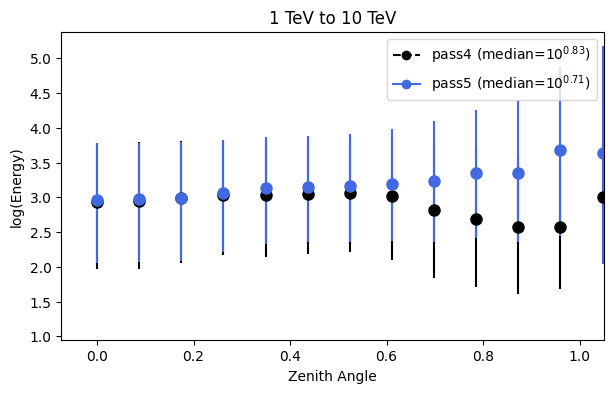

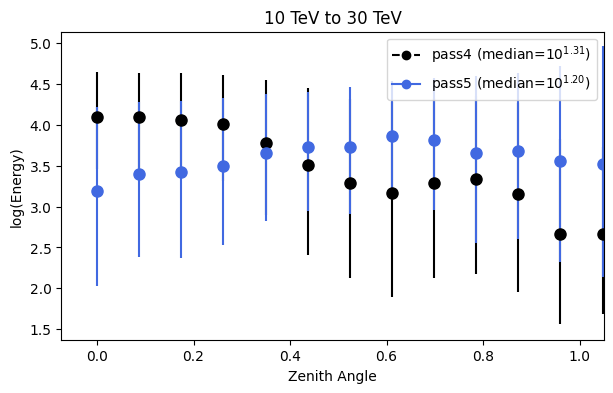

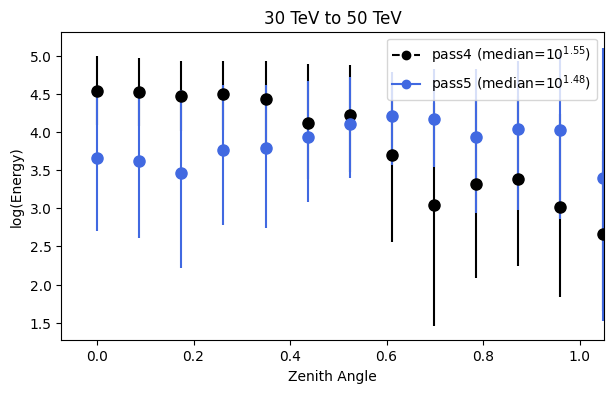

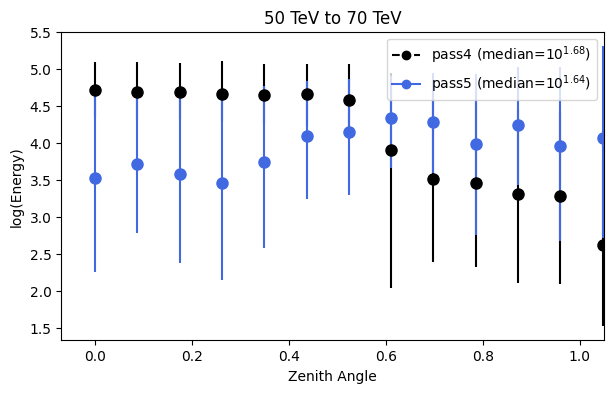

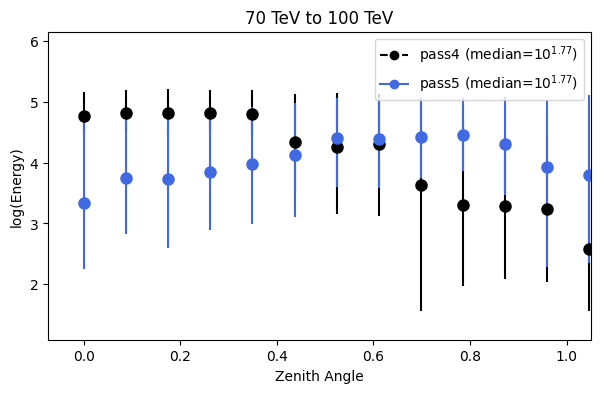

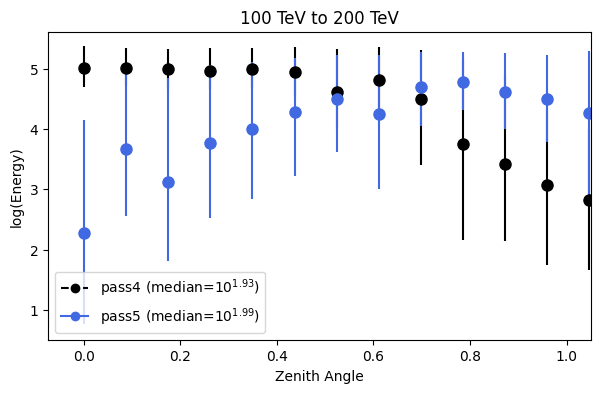

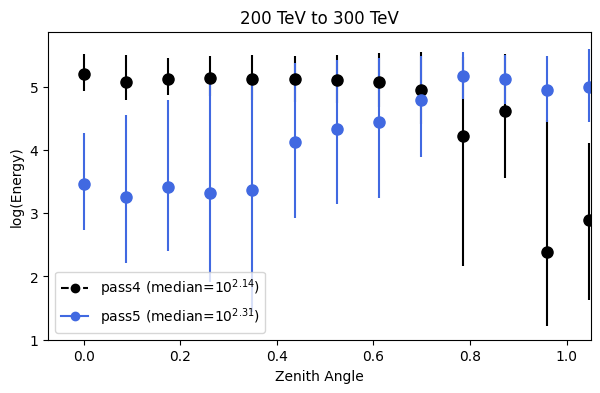

In [35]:
for i in range(7):  # Loop over the 7 cuts
    fig, ax = plt.subplots(figsize=(7, 4))
    medians = []

    for j, (energy_set, weight_set, zenith_set, color) in enumerate(zip(nn_energies, nn_weights_array, nn_zenith_array, colors)):
        energy = energy_set[i]
        weight = weight_set[i]
        zenith = zenith_set[i]
        median_energy = np.median(energy)
        medians.append(median_energy)

        for z in zbins:
            zmin = z
            zmax = z + deltaz
            zcut = np.logical_and(zenith >= zmin, zenith <= zmax)

            if not sum(weight[zcut] > 0):
                continue

            avg_energy = np.average(energy[zcut], weights=weight[zcut])
            upper_quantile = weighted_quantile(energy[zcut], 0.841, sample_weight=weight[zcut])
            lower_quantile = weighted_quantile(energy[zcut], 0.159, sample_weight=weight[zcut])

            err_upper = upper_quantile - avg_energy
            err_lower = avg_energy - lower_quantile
            err_lower = np.maximum(np.zeros(err_lower.size),err_lower)

            ax.errorbar(z, avg_energy, yerr=[[err_lower], [err_upper]], fmt='o', markersize=8, color=color, label=f'pass{4+j}' if z == zbins[0] else "")

    ax.set_xlabel('Zenith Angle')
    ax.set_ylabel('log(Energy)')
    ax.set_title(titles[i])
    ax.set_xlim(right = 1.05)  # 1.05 radians is 60 degrees
    
    proxy_pass4 = plt.Line2D([0], [0], linestyle='--', marker='o', color=colors[0])
    proxy_pass5 = plt.Line2D([0], [0], linestyle='-', marker='o', color=colors[1])

    median_pass4 = medians[0] - 3
    median_pass5 = medians[1] - 3
    
    ax.legend([proxy_pass4, proxy_pass5], [f'pass4 (median=$10^{{{median_pass4:.2f}}}$)', f'pass5 (median=$10^{{{median_pass5:.2f}}}$)'])
    
    plt.show()

## True energy with rec proton energy cuts

In [36]:
# applying the reconstructed nn energy cuts on true energy and add weights to them then plot it with the zenith

prot_energies = [prot_energies_4, prot_energies_5]
prot_weights_array = [prot_weights_array_4, prot_weights_array_5]
prot_zenith_array = [prot_zenith_array_4, prot_zenith_array_5]

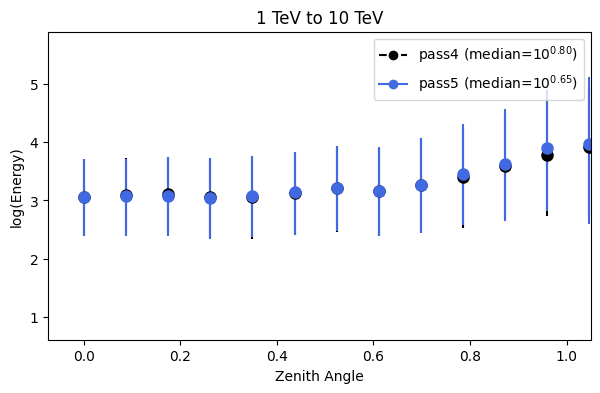

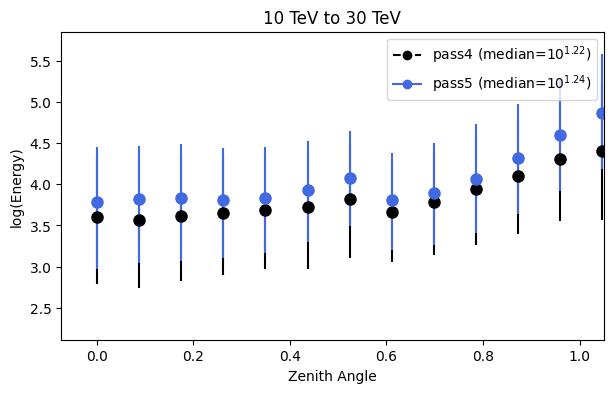

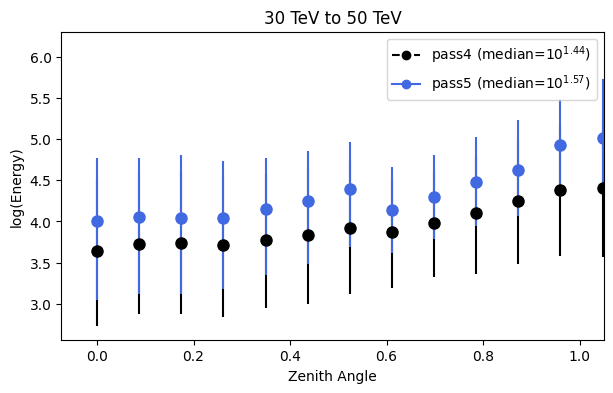

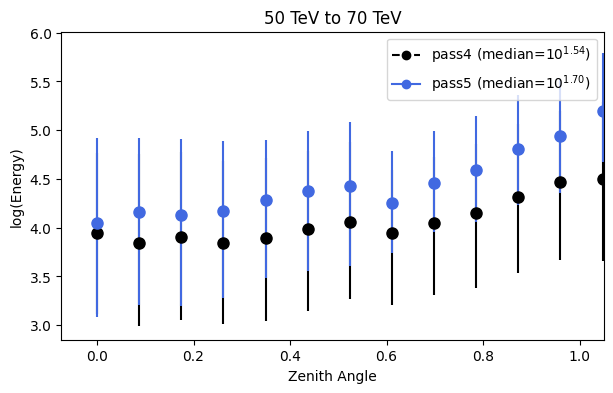

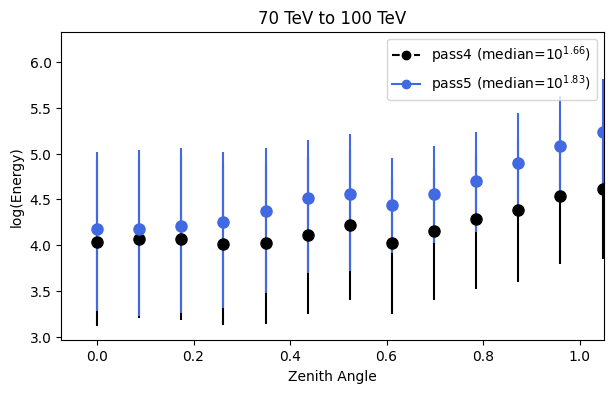

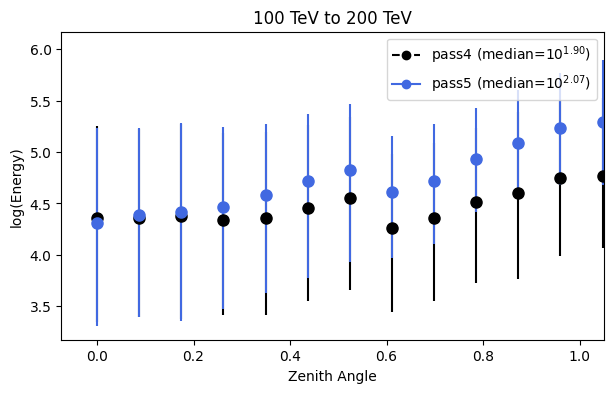

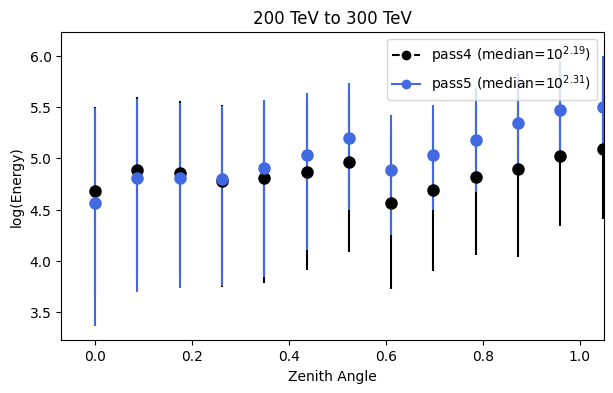

In [37]:
for i in range(7):  # Loop over the 7 cuts
    fig, ax = plt.subplots(figsize=(7, 4))
    medians = []

    for j, (energy_set, weight_set, zenith_set, color) in enumerate(zip(prot_energies, prot_weights_array, prot_zenith_array, colors)):
        energy = energy_set[i]
        weight = weight_set[i]
        zenith = zenith_set[i]
        median_energy = np.median(energy)
        medians.append(median_energy)

        for z in zbins:
            zmin = z
            zmax = z + deltaz
            zcut = np.logical_and(zenith >= zmin, zenith <= zmax)

            if not sum(weight[zcut] > 0):
                continue

            avg_energy = np.average(energy[zcut], weights=weight[zcut])
            upper_quantile = weighted_quantile(energy[zcut], 0.841, sample_weight=weight[zcut])
            lower_quantile = weighted_quantile(energy[zcut], 0.159, sample_weight=weight[zcut])

            err_upper = upper_quantile - avg_energy
            err_lower = avg_energy - lower_quantile
            err_lower = np.maximum(np.zeros(err_lower.size),err_lower)

            ax.errorbar(z, avg_energy, yerr=[[err_lower], [err_upper]], fmt='o', markersize=8, color=color, label=f'pass{4+j}' if z == zbins[0] else "")

    ax.set_xlabel('Zenith Angle')
    ax.set_ylabel('log(Energy)')
    ax.set_title(titles[i])
    ax.set_xlim(right = 1.05)  # 1.05 radians is 60 degrees
    
    proxy_pass4 = plt.Line2D([0], [0], linestyle='--', marker='o', color=colors[0])
    proxy_pass5 = plt.Line2D([0], [0], linestyle='-', marker='o', color=colors[1])

    median_pass4 = medians[0] - 3
    median_pass5 = medians[1] - 3
    
    ax.legend([proxy_pass4, proxy_pass5], [f'pass4 (median=$10^{{{median_pass4:.2f}}}$)', f'pass5 (median=$10^{{{median_pass5:.2f}}}$)'])
    
    plt.show()

# Histogram of cuts of energies for pass 4 and pass 5.1

## Viewing the cuts with respect to true energy

Define the cuts for reconstructed energy and apply those cuts on the true energy and plot

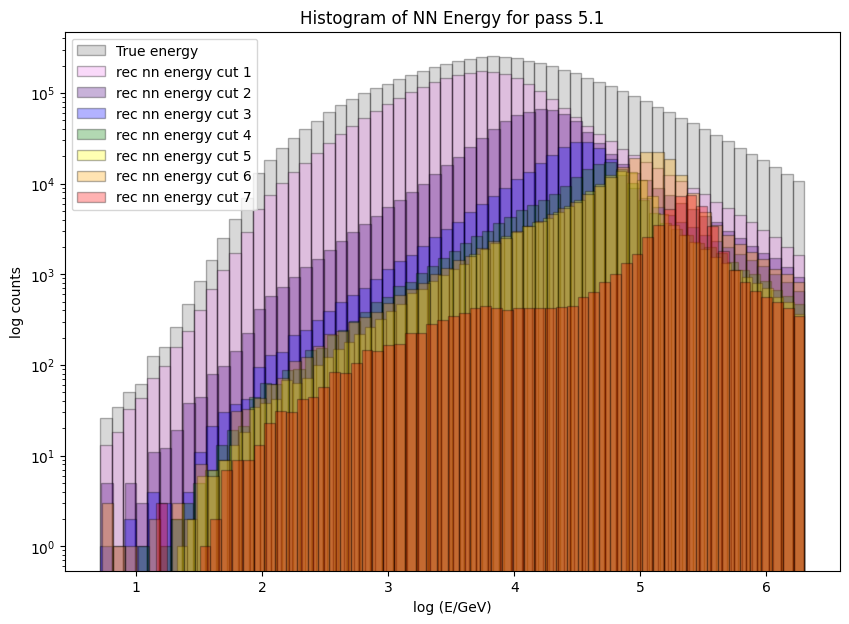

In [38]:
# histogram for pass 5.1 with all initial cuts applied
# use a for loop to plot all this
# also plot the median with a black line for each cut
plt.figure(figsize = (10,7))
plt.hist(true_log_E_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "True energy", edgecolor='black', color='grey')
plt.hist(nn_energy_cut1_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 1", edgecolor='black', color='violet')
plt.hist(nn_energy_cut2_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 2", edgecolor='black', color='indigo')
plt.hist(nn_energy_cut3_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 3", edgecolor='black', color='blue')
plt.hist(nn_energy_cut4_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 4", edgecolor='black', color='green')
plt.hist(nn_energy_cut5_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 5", edgecolor='black', color='yellow')
plt.hist(nn_energy_cut6_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 6", edgecolor='black', color='orange')
plt.hist(nn_energy_cut7_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 7", edgecolor='black', color='red')
plt.title("Histogram of NN Energy for pass 5.1")
plt.xlabel("log (E/GeV)")
plt.yscale('log')
plt.ylabel("log counts")
plt.legend()
plt.show()

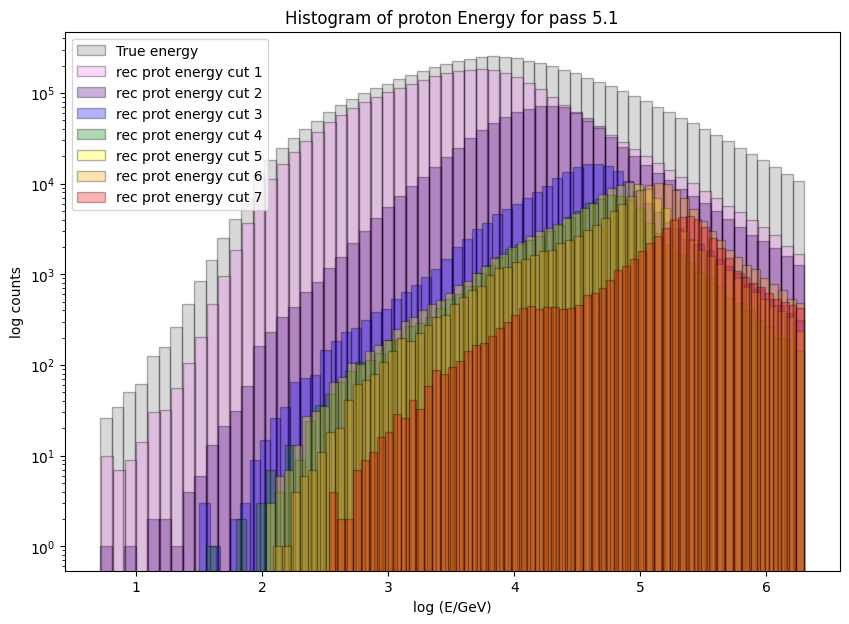

In [39]:
plt.figure(figsize = (10,7))
plt.hist(true_log_E_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "True energy", edgecolor='black', color='grey')
plt.hist(prot_energy_cut1_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 1", edgecolor='black', color='violet')
plt.hist(prot_energy_cut2_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 2", edgecolor='black', color='indigo')
plt.hist(prot_energy_cut3_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 3", edgecolor='black', color='blue')
plt.hist(prot_energy_cut4_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 4", edgecolor='black', color='green')
plt.hist(prot_energy_cut5_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 5", edgecolor='black', color='yellow')
plt.hist(prot_energy_cut6_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 6", edgecolor='black', color='orange')
plt.hist(prot_energy_cut7_5, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 7", edgecolor='black', color='red')
plt.title("Histogram of proton Energy for pass 5.1")
plt.xlabel("log (E/GeV)")
plt.yscale('log')
plt.ylabel("log counts")
plt.legend()
plt.show()

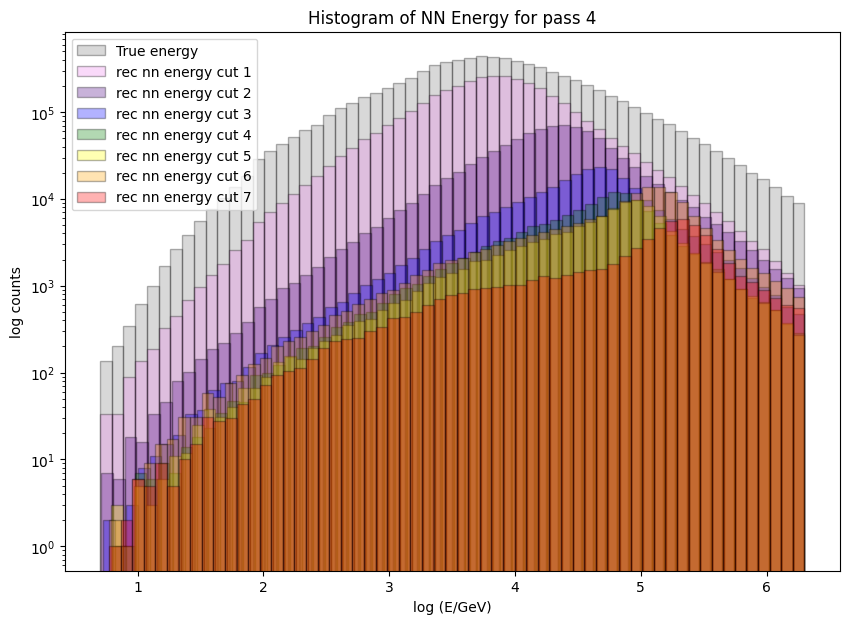

In [40]:
# histogram for pass 4 with all the inital cuts applied
# use a for loop to plot all this so that the cuts are easier to change and plot
plt.figure(figsize = (10,7))
plt.hist(true_log_E_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "True energy", edgecolor='black', color='grey')
plt.hist(nn_energy_cut1_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 1", edgecolor='black', color='violet')
plt.hist(nn_energy_cut2_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 2", edgecolor='black', color='indigo')
plt.hist(nn_energy_cut3_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 3", edgecolor='black', color='blue')
plt.hist(nn_energy_cut4_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 4", edgecolor='black', color='green')
plt.hist(nn_energy_cut5_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 5", edgecolor='black', color='yellow')
plt.hist(nn_energy_cut6_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 6", edgecolor='black', color='orange')
plt.hist(nn_energy_cut7_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec nn energy cut 7", edgecolor='black', color='red')
plt.title("Histogram of NN Energy for pass 4")
plt.xlabel("log (E/GeV)")
plt.yscale('log')
plt.ylabel("log counts")
plt.legend()
plt.show()

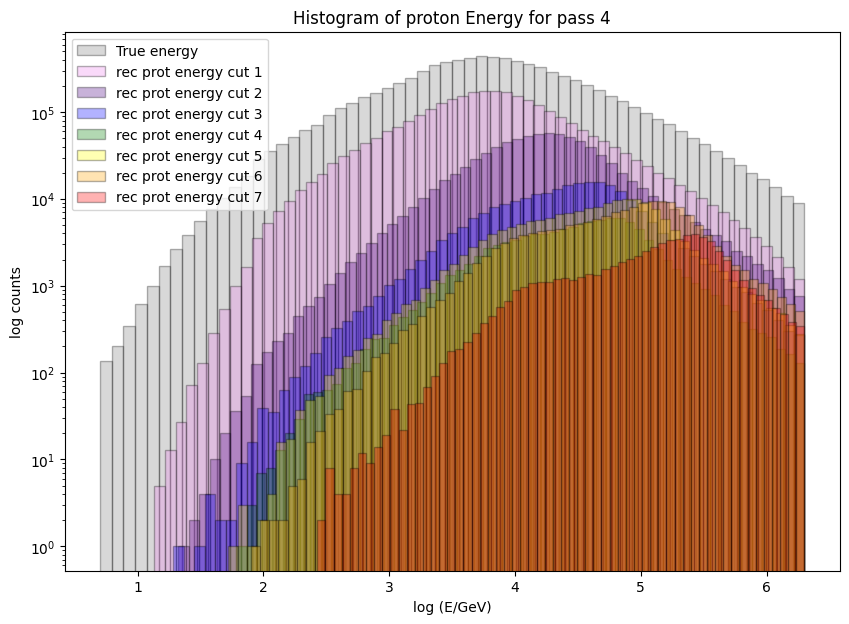

In [41]:
plt.figure(figsize = (10,7))
plt.hist(true_log_E_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "True energy", edgecolor='black', color='grey')
plt.hist(prot_energy_cut1_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 1", edgecolor='black', color='violet')
plt.hist(prot_energy_cut2_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 2", edgecolor='black', color='indigo')
plt.hist(prot_energy_cut3_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 3", edgecolor='black', color='blue')
plt.hist(prot_energy_cut4_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 4", edgecolor='black', color='green')
plt.hist(prot_energy_cut5_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 5", edgecolor='black', color='yellow')
plt.hist(prot_energy_cut6_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 6", edgecolor='black', color='orange')
plt.hist(prot_energy_cut7_4, bins = 60, histtype = 'bar', alpha = 0.3, label = "rec prot energy cut 7", edgecolor='black', color='red')
plt.title("Histogram of proton Energy for pass 4")
plt.xlabel("log (E/GeV)")
plt.yscale('log')
plt.ylabel("log counts")
plt.legend()
plt.show()

## Normalizing the Y axis

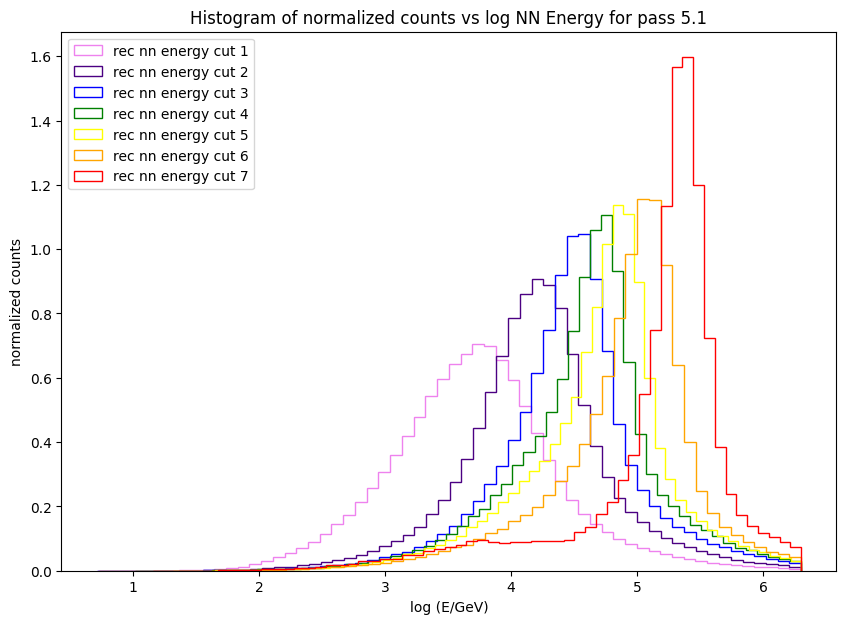

In [42]:
# normalizing the counts for pass 5.1 - rec nn energy

plt.figure(figsize = (10,7))
plt.hist(nn_energy_cut1_5, bins = 60, histtype = 'step', label = "rec nn energy cut 1", density = True, color='violet')
plt.hist(nn_energy_cut2_5, bins = 60, histtype = 'step', label = "rec nn energy cut 2", density = True, color='indigo')
plt.hist(nn_energy_cut3_5, bins = 60, histtype = 'step', label = "rec nn energy cut 3", density = True, color='blue')
plt.hist(nn_energy_cut4_5, bins = 60, histtype = 'step', label = "rec nn energy cut 4", density = True, color='green')
plt.hist(nn_energy_cut5_5, bins = 60, histtype = 'step', label = "rec nn energy cut 5", density = True, color='yellow')
plt.hist(nn_energy_cut6_5, bins = 60, histtype = 'step', label = "rec nn energy cut 6", density = True, color='orange')
plt.hist(nn_energy_cut7_5, bins = 60, histtype = 'step', label = "rec nn energy cut 7", density = True, color='red')
plt.title("Histogram of normalized counts vs log NN Energy for pass 5.1")
plt.xlabel("log (E/GeV)")
plt.ylabel("normalized counts")
plt.legend()
plt.show()

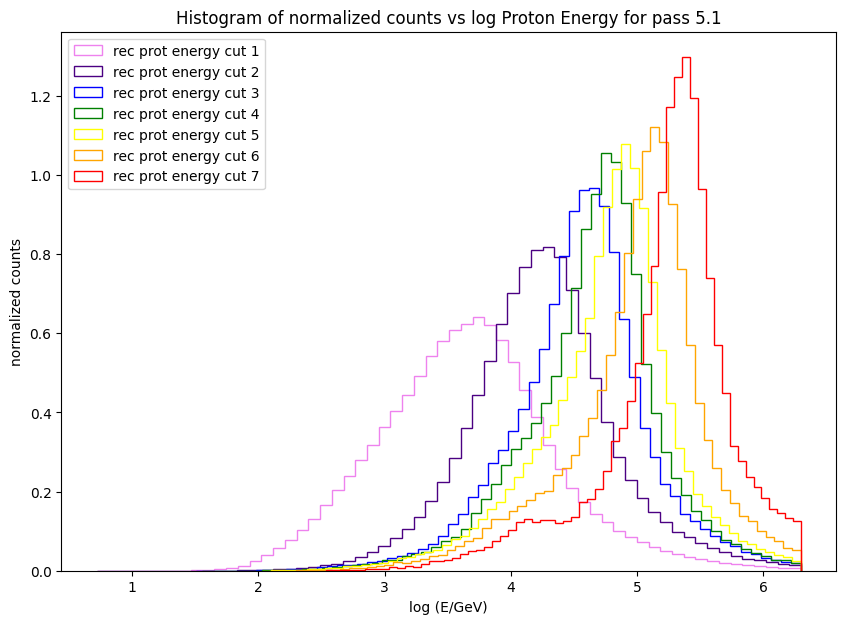

In [43]:
# normalizing the counts for pass 5.1 - rec proton energy

plt.figure(figsize = (10,7))
plt.hist(prot_energy_cut1_5, bins = 60, histtype = 'step', label = "rec prot energy cut 1", density = True, color='violet')
plt.hist(prot_energy_cut2_5, bins = 60, histtype = 'step', label = "rec prot energy cut 2", density = True, color='indigo')
plt.hist(prot_energy_cut3_5, bins = 60, histtype = 'step', label = "rec prot energy cut 3", density = True, color='blue')
plt.hist(prot_energy_cut4_5, bins = 60, histtype = 'step', label = "rec prot energy cut 4", density = True, color='green')
plt.hist(prot_energy_cut5_5, bins = 60, histtype = 'step', label = "rec prot energy cut 5", density = True, color='yellow')
plt.hist(prot_energy_cut6_5, bins = 60, histtype = 'step', label = "rec prot energy cut 6", density = True, color='orange')
plt.hist(prot_energy_cut7_5, bins = 60, histtype = 'step', label = "rec prot energy cut 7", density = True, color='red')
plt.title("Histogram of normalized counts vs log Proton Energy for pass 5.1")
plt.xlabel("log (E/GeV)")
plt.ylabel("normalized counts")
plt.legend()
plt.show()

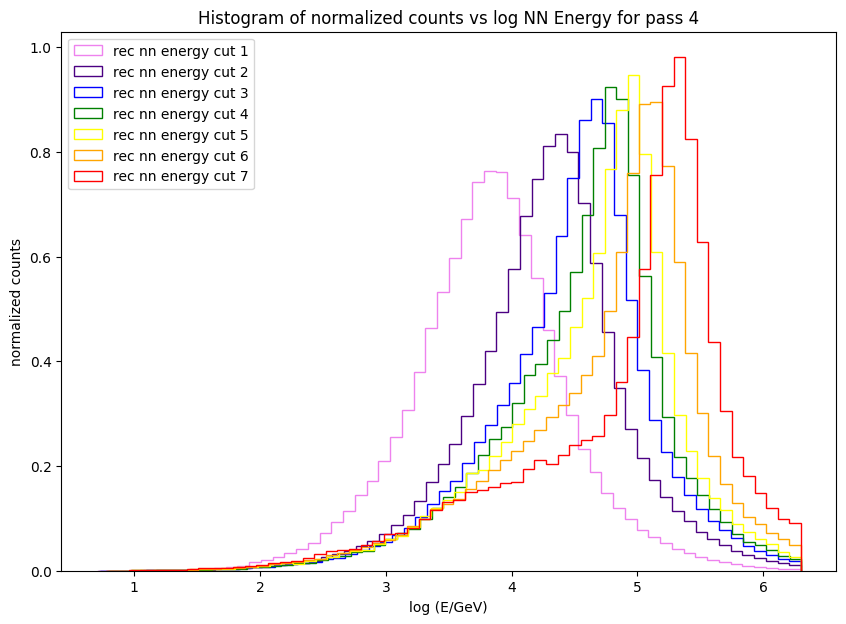

In [44]:
# normalizing the counts for pass 4 - rec nn energy

plt.figure(figsize = (10,7))
plt.hist(nn_energy_cut1_4, bins = 60, histtype = 'step', label = "rec nn energy cut 1", density = True, color='violet')
plt.hist(nn_energy_cut2_4, bins = 60, histtype = 'step', label = "rec nn energy cut 2", density = True, color='indigo')
plt.hist(nn_energy_cut3_4, bins = 60, histtype = 'step', label = "rec nn energy cut 3", density = True, color='blue')
plt.hist(nn_energy_cut4_4, bins = 60, histtype = 'step', label = "rec nn energy cut 4", density = True, color='green')
plt.hist(nn_energy_cut5_4, bins = 60, histtype = 'step', label = "rec nn energy cut 5", density = True, color='yellow')
plt.hist(nn_energy_cut6_4, bins = 60, histtype = 'step', label = "rec nn energy cut 6", density = True, color='orange')
plt.hist(nn_energy_cut7_4, bins = 60, histtype = 'step', label = "rec nn energy cut 7", density = True, color='red')
plt.title("Histogram of normalized counts vs log NN Energy for pass 4")
plt.xlabel("log (E/GeV)")
plt.ylabel("normalized counts")
plt.legend()
plt.show()

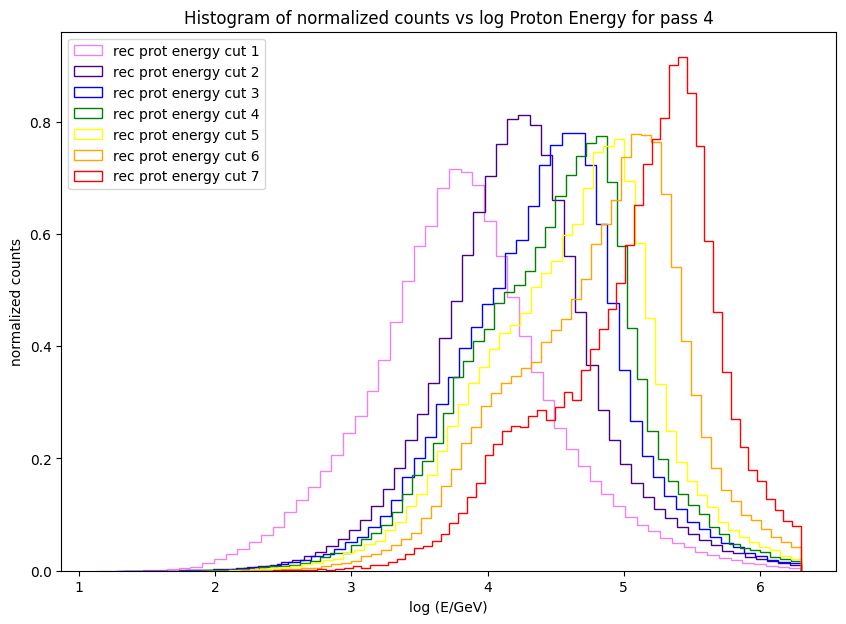

In [45]:
# normalizing the counts for pass 4 - rec proton energy

plt.figure(figsize = (10,7))
plt.hist(prot_energy_cut1_4, bins = 60, histtype = 'step', label = "rec prot energy cut 1", density = True, color='violet')
plt.hist(prot_energy_cut2_4, bins = 60, histtype = 'step', label = "rec prot energy cut 2", density = True, color='indigo')
plt.hist(prot_energy_cut3_4, bins = 60, histtype = 'step', label = "rec prot energy cut 3", density = True, color='blue')
plt.hist(prot_energy_cut4_4, bins = 60, histtype = 'step', label = "rec prot energy cut 4", density = True, color='green')
plt.hist(prot_energy_cut5_4, bins = 60, histtype = 'step', label = "rec prot energy cut 5", density = True, color='yellow')
plt.hist(prot_energy_cut6_4, bins = 60, histtype = 'step', label = "rec prot energy cut 6", density = True, color='orange')
plt.hist(prot_energy_cut7_4, bins = 60, histtype = 'step', label = "rec prot energy cut 7", density = True, color='red')
plt.title("Histogram of normalized counts vs log Proton Energy for pass 4")
plt.xlabel("log (E/GeV)")
plt.ylabel("normalized counts")
plt.legend()
plt.show()

# 3D Histogram

In [68]:
bin_sizes = {'coszen':30,'nhit':30, 'energy':10}

## Initial Functions

In [74]:
# Fill histogram with weighted data
def fillHist(h, d, weights,validation = False, nfiles=1):

    # Histogram values
    x = np.cos(np.asarray(d['zenith']))
    y = np.log10(d['nhit'])
    e = d['energy']
    # print(x)

    h0, bins = h
    
    # for k in d:
    #     print(k, d[k].shape)

    # Weight events
    w = weights

    if np.inf in w:        # Set infinite weights to zero
        w[w==np.inf] = 0

    if validation:
        h_train, h_valid = h0
        cut = np.random.uniform(size=x.shape) > 0.2
        h_train += np.histogramdd(np.transpose([x[cut], y[cut], e[cut]]),
                   bins=bins[1:], weights=w[cut])[0]
        h_valid += np.histogramdd(np.transpose([x[~cut], y[~cut], e[~cut]]),
                   bins=bins[1:], weights=w[~cut])[0]
        h0 = np.array([h_train, h_valid])

    else:

        
        h0 += np.histogramdd(np.transpose([x, y, e]), bins=bins, weights=w)[0]
        

    return (h0, bins)

def histPercentile(h, p, binMids):
    tot = h.sum()
    if tot == 0:
        return 0
    p_idx = np.where(h.cumsum()/tot > p/100)[0][0]
    return binMids[p_idx]

def histVar(h, binMids):
    if h.sum() == 0:
        return 0
    vals = np.asarray(binMids)
    ave = np.average(vals, weights=h)
    var = np.average((vals-ave)**2, weights=h)
    return var

def histMedian(h, bins):

    # Assume you only want to operate on the last dimension
    nx, ny, nz = h.shape
    median, sigL, sigR, var = np.zeros((4,nx,ny))
    emids = (bins[-1][:-1] + bins[-1][1:]) / 2
    for i in range(nx):
        for j in range(ny):
            median[i][j] = histPercentile(h[i][j], 50, emids)
            sigL[i][j]   = histPercentile(h[i][j], 16, emids)
            sigR[i][j]   = histPercentile(h[i][j], 84, emids)
            var[i][j]    = histVar(h[i][j], emids)

    return median, sigL, sigR, var


def cmap_discretize(cmap, bins):

    bins = np.array(bins)
    N = len(bins) - 1
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    diffs = bins[1:] - bins[:-1]
    diffs /= diffs.sum()
    indices = np.zeros(len(bins))
    for i, diff in enumerate(diffs):
        indices[i+1] = indices[i] + diff
    indices[-1] = 1
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) \
                for i in range(N+1)]
    return matplotlib.colors.LinearSegmentedColormap('Custom', cdict, 1024)

## Plotting Function

In [86]:
# merge the histogram function for pass 5.1 and pass 4 

In [87]:
def make_energy_histo_5(bin_sizes, emin=1, emax=6, coszenmin=0.3,coszenmax=1, nhitmin=1.5,nhitmax=3.1 ,title="HAWC Energy Response"):
    
    coszen_bins = np.linspace(0.3,1,bin_sizes['coszen'])
    hit_bins = np.linspace(1.5,3.1,bin_sizes['nhit'])
    ebins = np.linspace(emin, emax, bin_sizes['energy'])
    nx, ny, ne = len(coszen_bins)-1, len(hit_bins)-1, len(ebins)-1

    #h = (np.zeros((2, nx, ny, ne)), [[0,1,2], coszen_bins, hit_bins, ebins])
    h = (np.zeros((nx, ny, ne)), [coszen_bins, hit_bins, ebins])
    # cuts = dataset["mc"]["cuts"]
    #cuts = dataset["mc"]["logEnergy"]>.9
    energy = rec_prot_E_5
    zenith = zenith_angle_5
    weights = weights_5
    pinc = pinc_5
    # cxpe40x = dataset["mc"]["CxPE40XnCh"][cuts]
    mcenergy = true_log_E_5
    nhit = nHit_5


    d = {"zenith":zenith, "energy": mcenergy, "nhit":nhit}

    histo = fillHist(h, d, weights,validation = False,nfiles=1)

    #print(histo)
    h, bins = histo

    xbins, ybins, zbins = bins
    #ebins = getEbins() + [8]

        # Calculate spline / median energy values
    energies, sigL, sigR, var = histMedian(h, bins)


    # Additional options
    #energies[energies==0] = energies.max()      # 0 events only at high E
    #  - finer binning for x & y if using splines?
     #  - cmap.set_under('white')

     # Plot formatting
    # fig, ax = plt.subplots(figsize=(10,8))
    fig, ax = plt.subplots(figsize=(5,4))
    plt.rc("font", family="serif")
    tPars = {'fontsize':16}
    cmap = plt.cm.jet
    #cmap = cmap_discretize(cmap, ebins)
    cmap.set_under('white')

    # Plot
    X, Y = np.meshgrid(xbins, ybins)
    p = ax.pcolor(X, Y, energies.T, cmap=cmap, vmin=ebins[0], vmax=ebins[-1])
    cb = fig.colorbar(p, ax=ax, ticks=ebins)
    cb.ax.set_yticklabels(['%.2f' % ebin for ebin in ebins])
    cb.set_label(r'$\mathrm{log}_{10}(E/\mathrm{GeV})$',
                rotation=270, labelpad=20, **tPars)
    ax.set_xlabel(r'$\mathrm{cos}(\theta_\mathrm{reco})$', **tPars)
    ax.set_ylabel(r'$\mathrm{log}_{10}(N_\mathrm{Hit})$', **tPars)
    #ax.set_xlim(xbins.min(), xbins.max())
    #ax.set_ylim(ybins.min(), ybins.max())
    for item in (ax.get_xticklabels() + ax.get_yticklabels() + cb.ax.get_yticklabels()):
        item.set_fontsize(16)

    for item in cb.ax.get_yticklabels():
        item.set_fontsize(14)
    plt.title(title)
    plt.show()

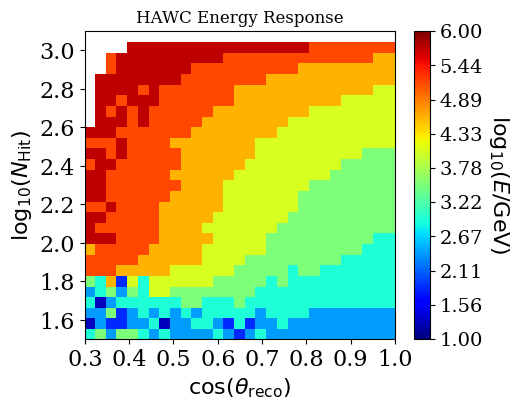

In [88]:
make_energy_histo_5(bin_sizes)

In [89]:
def make_energy_histo_4(bin_sizes, emin=1, emax=6, coszenmin=0.3,coszenmax=1, nhitmin=1.5,nhitmax=3.1 ,title="HAWC Energy Response"):
    
    coszen_bins = np.linspace(0.3,1,bin_sizes['coszen'])
    hit_bins = np.linspace(1.5,3.1,bin_sizes['nhit'])
    ebins = np.linspace(emin, emax, bin_sizes['energy'])
    nx, ny, ne = len(coszen_bins)-1, len(hit_bins)-1, len(ebins)-1

    #h = (np.zeros((2, nx, ny, ne)), [[0,1,2], coszen_bins, hit_bins, ebins])
    h = (np.zeros((nx, ny, ne)), [coszen_bins, hit_bins, ebins])
    # cuts = dataset["mc"]["cuts"]
    #cuts = dataset["mc"]["logEnergy"]>.9
    energy = rec_prot_E_4
    zenith = zenith_angle_4
    weights = weights_4
    pinc = pinc_4
    # cxpe40x = dataset["mc"]["CxPE40XnCh"][cuts]
    mcenergy = true_log_E_4
    nhit = nHit_4


    d = {"zenith":zenith, "energy": mcenergy, "nhit":nhit}

    histo = fillHist(h, d, weights,validation = False,nfiles=1)

    #print(histo)
    h, bins = histo

    xbins, ybins, zbins = bins
    #ebins = getEbins() + [8]

        # Calculate spline / median energy values
    energies, sigL, sigR, var = histMedian(h, bins)


    # Additional options
    #energies[energies==0] = energies.max()      # 0 events only at high E
    #  - finer binning for x & y if using splines?
     #  - cmap.set_under('white')

     # Plot formatting
    # fig, ax = plt.subplots(figsize=(10,8))
    fig, ax = plt.subplots(figsize=(5,4))
    plt.rc("font", family="serif")
    tPars = {'fontsize':16}
    cmap = plt.cm.jet
    #cmap = cmap_discretize(cmap, ebins)
    cmap.set_under('white')

    # Plot
    X, Y = np.meshgrid(xbins, ybins)
    p = ax.pcolor(X, Y, energies.T, cmap=cmap, vmin=ebins[0], vmax=ebins[-1])
    cb = fig.colorbar(p, ax=ax, ticks=ebins)
    cb.ax.set_yticklabels(['%.2f' % ebin for ebin in ebins])
    cb.set_label(r'$\mathrm{log}_{10}(E/\mathrm{GeV})$',
                rotation=270, labelpad=20, **tPars)
    ax.set_xlabel(r'$\mathrm{cos}(\theta_\mathrm{reco})$', **tPars)
    ax.set_ylabel(r'$\mathrm{log}_{10}(N_\mathrm{Hit})$', **tPars)
    #ax.set_xlim(xbins.min(), xbins.max())
    #ax.set_ylim(ybins.min(), ybins.max())
    for item in (ax.get_xticklabels() + ax.get_yticklabels() + cb.ax.get_yticklabels()):
        item.set_fontsize(16)

    for item in cb.ax.get_yticklabels():
        item.set_fontsize(14)
    plt.title(title)
    plt.show()

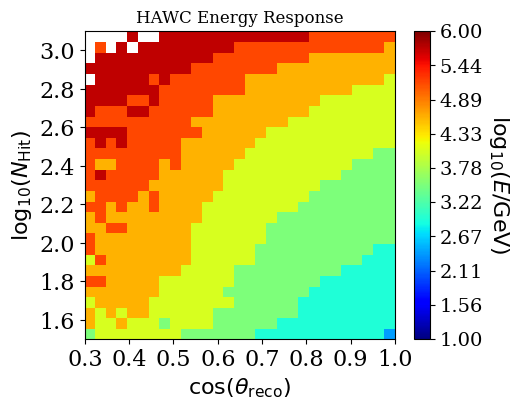

In [90]:
make_energy_histo_4(bin_sizes)

# Plotting the equation

\$ \frac{d \log{\phi} (E)}{\log{E}} = \gamma_{1} + (\gamma_{2} - \gamma_{1}) \frac{\left( \frac{E}{E_{o}} \right)^{\varepsilon}}{1 + \left( \frac{E}{E_{o}} \right)^{\varepsilon}}  \$

In [40]:
g1 = -2.52
g2 = -2.71
E0 = 3.87e4
eps = 3
def func(E):
    y = g1 + (g2 - g1)*((((E)/E0)**eps)/(1 + ((E)/E0)**eps))
    return y

In [41]:
specind1 = func(10**(true_log_E_5))

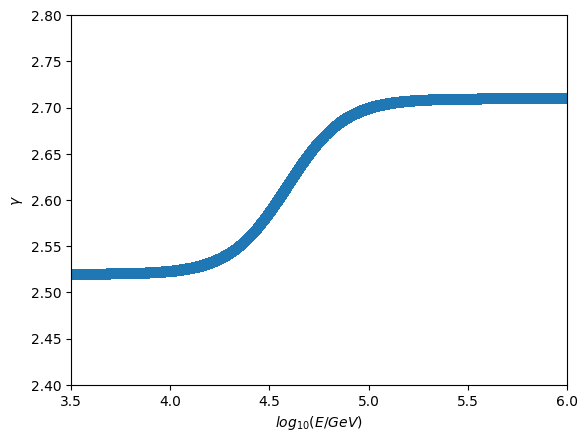

In [42]:
# true energy

plt.scatter(true_log_E_5, np.abs(specind1))
plt.ylim(2.4, 2.8)
plt.xlim(3.5,6)
plt.xlabel("$ log_{10} (E/GeV) $")
plt.ylabel("$ \gamma $")
plt.show()

In [ ]:
# def make_energy_histo(dataset, bin_sizes, emin=1, emax=6, coszenmin=0.3,coszenmax=1, nhitmin=1.5,nhitmax=3.1 ,title="HAWC Energy Response"):
    
#     coszen_bins = np.linspace(0.3,1,bin_sizes['coszen'])
#     hit_bins = np.linspace(1.5,3.1,bin_sizes['nhit'])
#     ebins = np.linspace(emin, emax, bin_sizes['energy'])
#     nx, ny, ne = len(coszen_bins)-1, len(hit_bins)-1, len(ebins)-1

#     #h = (np.zeros((2, nx, ny, ne)), [[0,1,2], coszen_bins, hit_bins, ebins])
#     h = (np.zeros((nx, ny, ne)), [coszen_bins, hit_bins, ebins])
#     cuts = dataset["mc"]["cuts"]
#     #cuts = dataset["mc"]["logEnergy"]>.9
#     energy = dataset["mc"]["protonlheEnergy"][cuts]-9
#     zenith = dataset["mc"]["zenithAngle"][cuts]
#     weights = dataset["mc"]["weights"][cuts]
#     pinc = dataset["mc"]["PINC"][cuts]
#     cxpe40x = dataset["mc"]["CxPE40XnCh"][cuts]
#     mcenergy = dataset["mc"]["logEnergy"][cuts]
#     nhit = dataset["mc"]["nHit"][cuts]


#     d = {"zenith":zenith, "energy": mcenergy, "nhit":nhit}

#     histo = fillHist(h, d, weights,validation = False,nfiles=1)

#     #print(histo)
#     h, bins = histo

#     xbins, ybins, zbins = bins
#     #ebins = getEbins() + [8]

#         # Calculate spline / median energy values
#     energies, sigL, sigR, var = histMedian(h, bins)


#     # Additional options
#     #energies[energies==0] = energies.max()      # 0 events only at high E
#     #  - finer binning for x & y if using splines?
#      #  - cmap.set_under('white')

#      # Plot formatting
#     fig, ax = plt.subplots(figsize=(10,8))
#     #fig, ax = plt.subplots(figsize=(5,4))
#     matplotlib.rc("font", family="serif")
#     tPars = {'fontsize':16}
#     cmap = plt.cm.jet
#     #cmap = cmap_discretize(cmap, ebins)
#     cmap.set_under('white')

#     # Plot
#     X, Y = np.meshgrid(xbins, ybins)
#     p = ax.pcolor(X, Y, energies.T, cmap=cmap, vmin=ebins[0], vmax=ebins[-1])
#     cb = fig.colorbar(p, ax=ax, ticks=ebins)
#     cb.ax.set_yticklabels(['%.2f' % ebin for ebin in ebins])
#     cb.set_label(r'$\mathrm{log}_{10}(E/\mathrm{GeV})$',
#                 rotation=270, labelpad=20, **tPars)
#     ax.set_xlabel(r'$\mathrm{cos}(\theta_\mathrm{reco})$', **tPars)
#     ax.set_ylabel(r'$\mathrm{log}_{10}(N_\mathrm{Hit})$', **tPars)
#     #ax.set_xlim(xbins.min(), xbins.max())
#     #ax.set_ylim(ybins.min(), ybins.max())
#     for item in (ax.get_xticklabels() + ax.get_yticklabels() + cb.ax.get_yticklabels()):
#         item.set_fontsize(16)

#     for item in cb.ax.get_yticklabels():
#         item.set_fontsize(14)
#     plt.title(title)
#     plt.show()